#**🕋 Managing Crowds During Hajj and Umrah**
**Imagine this**: every year, millions of pilgrims from all over the world gather in Saudi Arabia for Hajj and Umrah, one of the largest human gatherings on the planet 🌍. It's a deeply spiritual and transformative experience for everyone involved, but it also presents unique challenges.



**What’s the Big Deal?**

Handling huge crowds is no easy task. Overcrowding in places like Masjid al-Haram in Makkah or Mina during the rituals can lead to:


* 🚑 Safety risks (e.g., stampedes or congestion-related incidents).


* 😓 Stressful experiences for pilgrims.


* ❌ Inefficiency in resource allocation and crowd management.




**What If AI Could Make Pilgrimage Safer?**

Now, imagine if we could predict crowd density, movement patterns, and behavior before things get chaotic. This is where deep learning and computer vision can step in as powerful tools. By analyzing real-time images of crowds, we can:


* Track crowd density to avoid overcrowded zones.

* Make pilgrimage experiences safer, smoother, and more organized for everyone.


**Why It Matters?**

This is more than just a technical problem—it's a humanitarian challenge. With AI-powered crowd monitoring, we have the potential to:

*   Save lives. ❤️

*   Enhance the spiritual experience for millions of people. 🕋

* Support efficient planning for future pilgrimages. 📊



So, let’s dive into how we tackled this fascinating challenge step by step! 🎯

#**Setting Up the Environment**

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import shutil
from collections import Counter
import random
import os
import cv2
import numpy as np
from tqdm import tqdm



train_path = "/content/Train"
test_path = "/content/Test"
valid_path = "/content/Valid"

#**Exploratory Data Analysis**

In this part of the exploratory data analysis (EDA), we:

1- Extracted and displayed the class names from the dataset to understand the categories being used.


2- Processed bounding box coordinates for each image and linked them to their respective classes.

3- Showed a few training images with annotated bounding boxes to verify data quality.

Class Names: ['crowded', 'not-crowded']


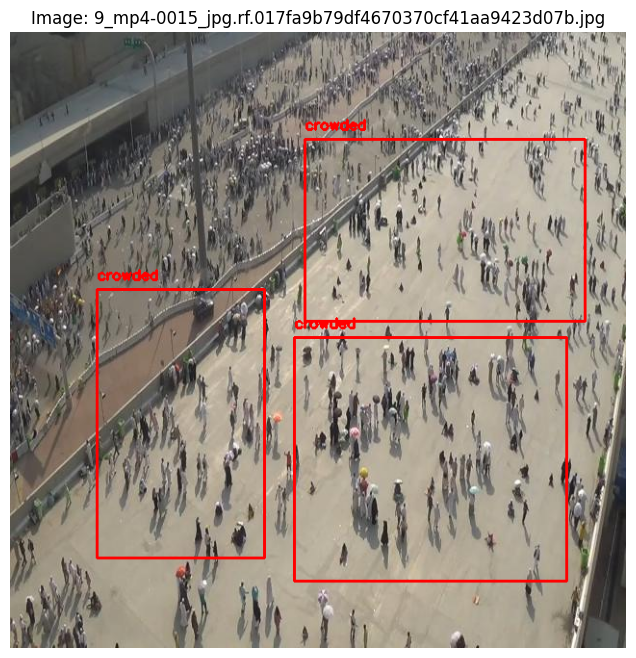

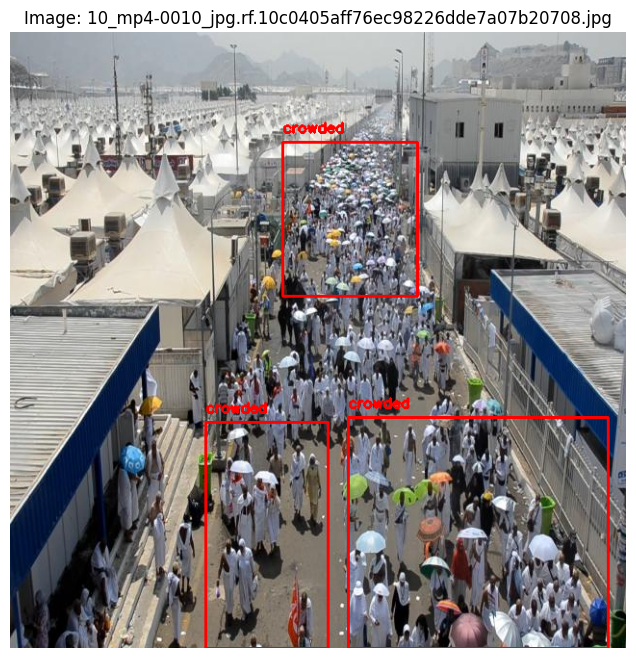

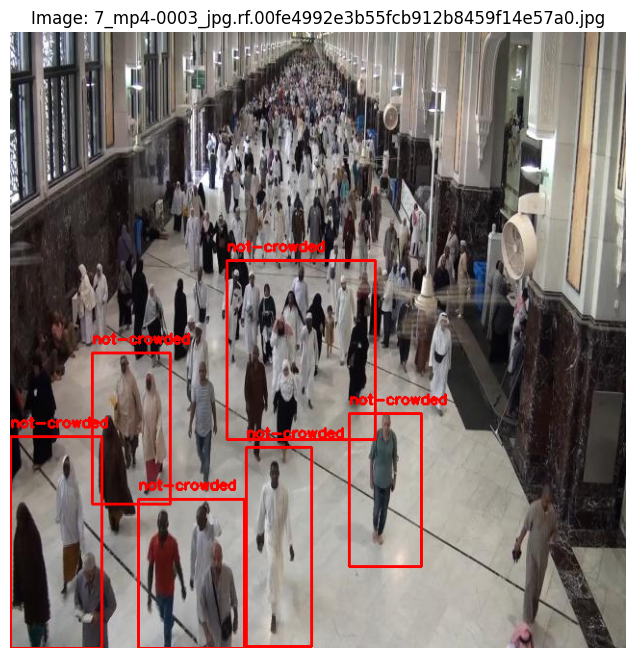

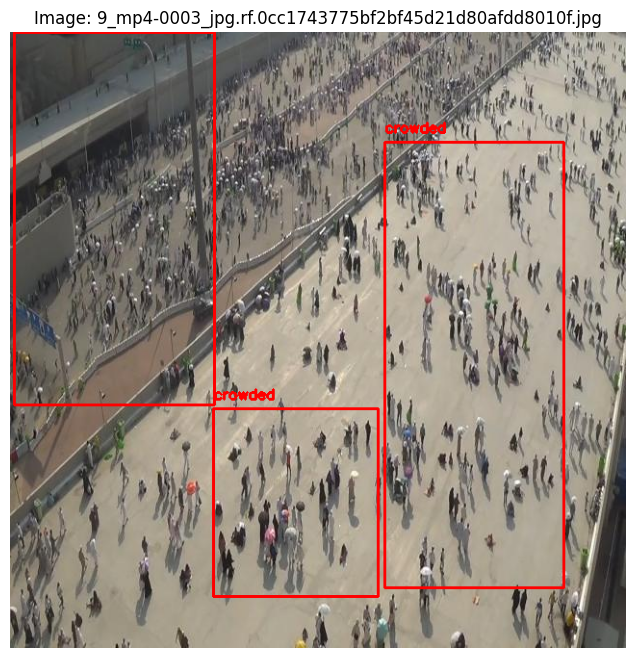

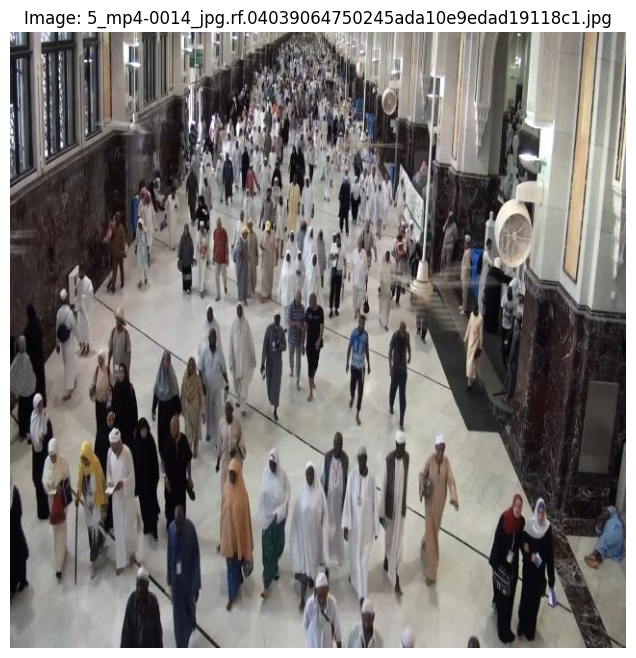

In [ ]:
# Classes
classes_file = os.path.join(train_path, "_classes.txt")
with open(classes_file, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
print("Class Names:", class_names)

# Function to Parse Annotations
def parse_annotations(annotations_file):
    annotations = []
    with open(annotations_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            bboxes = []
            for bbox in parts[1:]:
                coords = bbox.split(",")
                x_min, y_min, x_max, y_max, class_id = map(int, coords)
                bboxes.append((x_min, y_min, x_max, y_max, class_names[class_id]))
            annotations.append((image_name, bboxes))
    return annotations

# Load and Parse Annotations
train_annotations_file = os.path.join(train_path, "_annotations.txt")
train_annotations = parse_annotations(train_annotations_file)

# Visualize a Few Examples
def visualize_annotations(image_folder, annotations, num_images=5):
    for i, (image_name, bboxes) in enumerate(annotations[:num_images]):
        image_path = os.path.join(image_folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for (x_min, y_min, x_max, y_max, label) in bboxes:
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Image: {image_name}")
        plt.axis("off")
        plt.show()

# Visualize Train Annotations
visualize_annotations(train_path, train_annotations)


The dataset is well-organized with clear bounding boxes and labels. These visuals provide valuable insights into how the model will perceive the data. A great start for understanding our dataset!

In [ ]:
# Load Annotations
def load_annotations(folder_path):
    annotations_file = os.path.join(folder_path, "_annotations.txt")
    annotations = []
    with open(annotations_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            bboxes = []
            for bbox in parts[1:]:
                coords = bbox.split(",")
                x_min, y_min, x_max, y_max, class_id = map(int, coords)
                bboxes.append((x_min, y_min, x_max, y_max, class_id))
            annotations.append((image_name, bboxes))
    return annotations

# Load Train, Test, and Validation Annotations
train_annotations = load_annotations(train_path)
test_annotations = load_annotations(test_path)
valid_annotations = load_annotations(valid_path)

# Count Images and Bounding Boxes
def count_images_and_bboxes(annotations):
    num_images = len(annotations)
    num_bboxes = sum(len(bboxes) for _, bboxes in annotations)
    return num_images, num_bboxes

train_images, train_bboxes = count_images_and_bboxes(train_annotations)
test_images, test_bboxes = count_images_and_bboxes(test_annotations)
valid_images, valid_bboxes = count_images_and_bboxes(valid_annotations)

print(f"Train Dataset: {train_images} images, {train_bboxes} bounding boxes")
print(f"Test Dataset: {test_images} images, {test_bboxes} bounding boxes")
print(f"Validation Dataset: {valid_images} images, {valid_bboxes} bounding boxes")

Train Dataset: 118 images, 618 bounding boxes
Test Dataset: 16 images, 86 bounding boxes
Validation Dataset: 33 images, 165 bounding boxes


The Train dataset contains 118 images and 618 bounding boxes. This indicates that there is an average of approximately 5.2 bounding boxes per image in the training set.


Class Distribution (Overall):
Class 0: 646 instances
Class 1: 223 instances


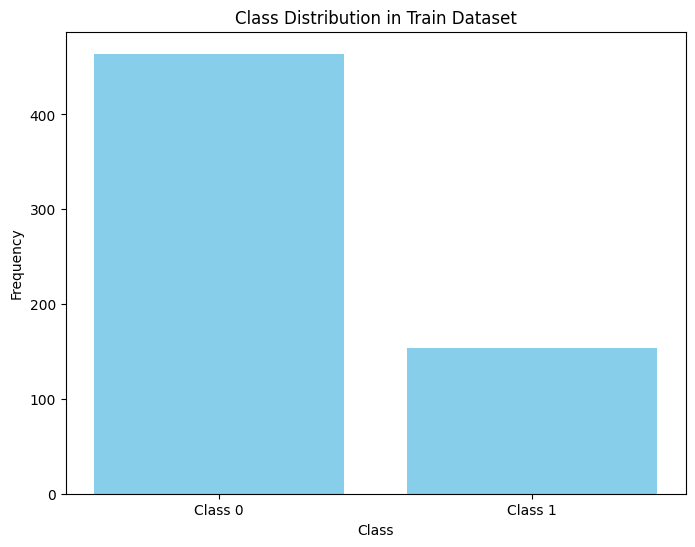

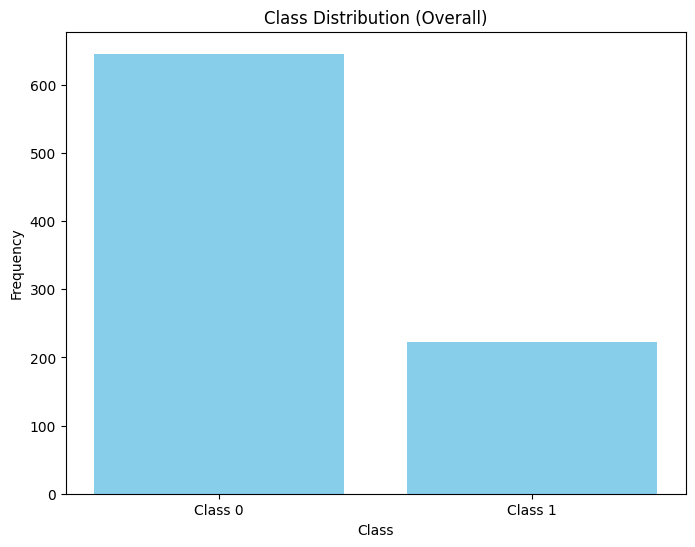

In [ ]:
# Analyze Class Distribution
def class_distribution(annotations):
    class_counts = {}
    for _, bboxes in annotations:
        for _, _, _, _, class_id in bboxes:
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
    return class_counts

train_class_dist = class_distribution(train_annotations)
test_class_dist = class_distribution(test_annotations)
valid_class_dist = class_distribution(valid_annotations)

# Combine All Class Distributions
combined_class_dist = {
    class_id: train_class_dist.get(class_id, 0) + test_class_dist.get(class_id, 0) + valid_class_dist.get(class_id, 0)
    for class_id in set(train_class_dist) | set(test_class_dist) | set(valid_class_dist)
}

print("\nClass Distribution (Overall):")
for class_id, count in combined_class_dist.items():
    print(f"Class {class_id}: {count} instances")

# Visualize Class Distribution
def plot_class_distribution(class_dist, title):
    labels = [f"Class {key}" for key in class_dist.keys()]
    values = class_dist.values()
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color="skyblue")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

plot_class_distribution(train_class_dist, "Class Distribution in Train Dataset")
plot_class_distribution(combined_class_dist, "Class Distribution (Overall)")


Class 0 (not-crowded) has 646 instances, while Class 1 (crowded) has 223 instances in the overall dataset.
This imbalance suggests that there are significantly more examples of not-crowded scenes.

To address this, techniques like oversampling (duplicating examples from the minority class) or class weighting during training will be used to ensure the model does not become biased towards the majority class.


Visualizing the class distribution also highlights the need for careful evaluation of performance metrics like precision and recall to assess how well the model handles the minority class.

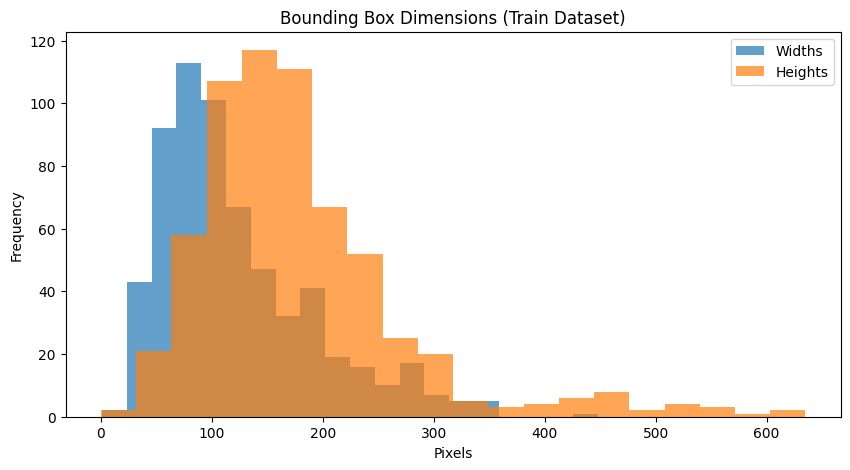

In [ ]:
# Bounding Box Dimensions Analysis
def bbox_dimensions(annotations):
    widths, heights = [], []
    for _, bboxes in annotations:
        for x_min, y_min, x_max, y_max, _ in bboxes:
            widths.append(x_max - x_min)
            heights.append(y_max - y_min)
    return widths, heights

train_widths, train_heights = bbox_dimensions(train_annotations)

# Plot Bounding Box Dimensions
plt.figure(figsize=(10, 5))
plt.hist(train_widths, bins=20, alpha=0.7, label="Widths")
plt.hist(train_heights, bins=20, alpha=0.7, label="Heights")
plt.title("Bounding Box Dimensions (Train Dataset)")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The histogram shows the distribution of bounding box widths and heights in the training dataset. Most bounding boxes have widths and heights in the range of 50-200 pixels, indicating that the majority of objects (crowded or not-crowded regions) are relatively small.

This information is vital for selecting the input image resolution during model training. If bounding boxes are too small, the model may struggle to detect them on lower-resolution images. Ensuring an appropriate image size and feature map resolution during training is crucial for effective detection.

Additionally, understanding bounding box dimensions can guide the selection of anchor box sizes for object detection models like YOLO or Faster R-CNN.


#**Data Preprocessing**


In this preprocessing section, we will do 4 preprocessing steps:

1- Balancing the Dataset through Oversampling

2- Resizing Images

3- Adjusting Bounding Boxes

4- Normalizing Images

Then we will save the processed images in a new folder



**1. Balancing The dataset**

In [ ]:
import os
import shutil
from collections import Counter
import random

# Paths
augmented_path = "/content/augmented__train_folder"  # Path to store augmented training data
os.makedirs(augmented_path, exist_ok=True)  # Ensure the augmented path exists

# Parse Annotations
def parse_annotations(annotations_file):
    annotations = []
    with open(annotations_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            bboxes = []
            for bbox in parts[1:]:
                coords = bbox.split(",")
                x_min, y_min, x_max, y_max, class_id = map(int, coords)
                bboxes.append((x_min, y_min, x_max, y_max, class_id))
            annotations.append((image_name, bboxes))
    return annotations

# Save Updated Annotations
def save_annotations(annotations, output_file):
    with open(output_file, "w") as f:
        for image_name, bboxes in annotations:
            line = [image_name] + [",".join(map(str, bbox)) for bbox in bboxes]
            f.write(" ".join(line) + "\n")

# Load Annotations
train_annotations_file = os.path.join(train_path, "_annotations.txt")
train_annotations = parse_annotations(train_annotations_file)

# Count Class Distribution
class_counts = Counter(bbox[4] for _, bboxes in train_annotations for bbox in bboxes)
print("Class Counts (Before Oversampling):", class_counts)
# Oversampling to Match Majority Class with Exact Parity
max_class_count = max(class_counts.values())  # Target count for both classes
minority_class = 1  # Class to oversample
majority_class = 0  # Class with the larger count

augmented_annotations = train_annotations.copy()

for image_name, bboxes in train_annotations:
    # Only process images with the minority class
    if any(bbox[4] == minority_class for bbox in bboxes):
        while class_counts[minority_class] < max_class_count:  # Continue until exact parity
            new_image_name = f"aug_{random.randint(0, 1e6)}_{image_name}"
            original_image_path = os.path.join(train_path, image_name)
            new_image_path = os.path.join(augmented_path, new_image_name)

            # Copy the image
            shutil.copy(original_image_path, new_image_path)

            # Add annotations
            augmented_annotations.append((new_image_name, bboxes))
            class_counts[minority_class] += len([b for b in bboxes if b[4] == minority_class])

            # Stop if class parity is achieved
            if class_counts[minority_class] >= max_class_count:
                break

# Save Augmented Annotations
augmented_annotations_file = os.path.join(augmented_path, "_annotations.txt")
save_annotations(augmented_annotations, augmented_annotations_file)

# Recount Class Distribution
new_class_counts = Counter(bbox[4] for _, bboxes in augmented_annotations for bbox in bboxes)
print("Class Counts (After Final Oversampling):", new_class_counts)


Class Counts (Before Oversampling): Counter({0: 464, 1: 154})
Class Counts (After Final Oversampling): Counter({1: 466, 0: 464})


 we addressed the class imbalance in our dataset by:

* Counted instances of each class in the training dataset.

* Oversampled images with the minority class to achieve parity with the majority class by duplicating images and annotations.

* Updated and saved the new annotations alongside the augmented images.

Final Class Counts: Counter({1: 466, 0: 464})


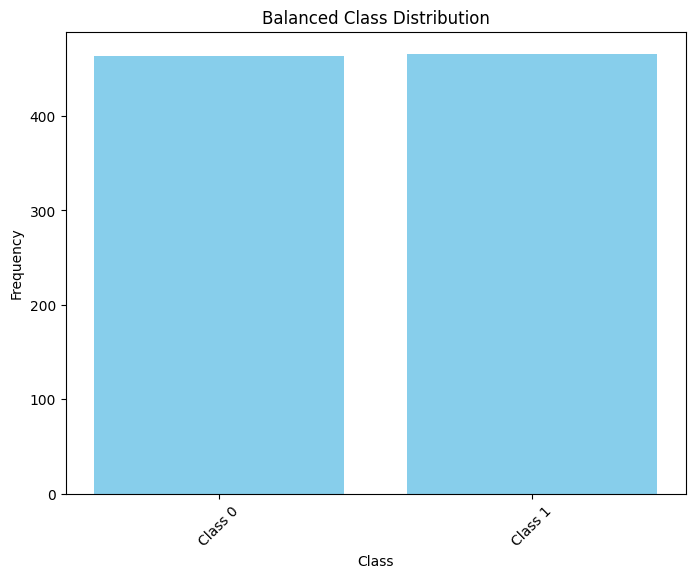

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Parse Annotations
def parse_annotations(annotations_file):
    annotations = []
    with open(annotations_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            bboxes = []
            for bbox in parts[1:]:
                coords = bbox.split(",")
                x_min, y_min, x_max, y_max, class_id = map(int, coords)
                bboxes.append((x_min, y_min, x_max, y_max, class_id))
            annotations.append((image_name, bboxes))
    return annotations

# Load the Augmented Annotations File
augmented_annotations_file = "/content/augmented__train_folder/_annotations.txt"  # Update to actual path
augmented_annotations = parse_annotations(augmented_annotations_file)

# Count Classes
final_class_counts = Counter(bbox[4] for _, bboxes in augmented_annotations for bbox in bboxes)
print("Final Class Counts:", final_class_counts)

# Plot Balanced Class Distribution
def plot_class_distribution(class_counts, title):
    labels = [f"Class {cls}" for cls in class_counts.keys()]
    values = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color="skyblue")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(final_class_counts, "Balanced Class Distribution")


Wow we have balanced dataset now!

To address the class imbalance in the dataset, we employed an oversampling technique. The dataset initially had a significant imbalance with 464 instances of Class 0 (not-crowded) and only 154 instances of Class 1 (crowded). By duplicating images containing bounding boxes for the minority class (Class 1), we incrementally increased its representation until it matched the count of the majority class. This oversampling process was carefully controlled to avoid over-representing any single image excessively.

As a result, the final dataset achieved near-perfect balance, with Class 0 having 464 instances and Class 1 having 466 instances.


**2. Resize Images, Adjust Bounding Boxes and Normalize Imgaes**

In [ ]:
# Paths
train_path = "/content/augmented__train_folder"  # Path to augmented training data
preprocessed_path = "/content/preprocessed__data"  # Output folder for preprocessed data
os.makedirs(preprocessed_path, exist_ok=True)

# Parameters
IMG_SIZE = 416  # Target image size (e.g., 416x416)

# Parse Annotations
def parse_annotations(annotations_file):
    annotations = []
    with open(annotations_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            bboxes = []
            for bbox in parts[1:]:
                coords = bbox.split(",")
                x_min, y_min, x_max, y_max, class_id = map(int, coords)
                bboxes.append((x_min, y_min, x_max, y_max, class_id))
            annotations.append((image_name, bboxes))
    return annotations

# Resize Image and Adjust Bounding Boxes
def resize_image_and_bboxes(image, bboxes, target_size):
    h, w = image.shape[:2]
    scale_x = target_size / w
    scale_y = target_size / h

    # Resize image
    resized_image = cv2.resize(image, (target_size, target_size))

    # Adjust bounding boxes
    resized_bboxes = []
    for (x_min, y_min, x_max, y_max, class_id) in bboxes:
        x_min = int(x_min * scale_x)
        y_min = int(y_min * scale_y)
        x_max = int(x_max * scale_x)
        y_max = int(y_max * scale_y)
        resized_bboxes.append((x_min, y_min, x_max, y_max, class_id))

    return resized_image, resized_bboxes

# Preprocess Dataset
def preprocess_dataset(input_path, output_path, img_size):
    annotations_file = os.path.join(input_path, "_annotations.txt")
    annotations = parse_annotations(annotations_file)
    preprocessed_annotations = []

    for image_name, bboxes in tqdm(annotations, desc="Processing Images"):
        image_path = os.path.join(input_path, image_name)

        # Load Image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to load {image_path}")
            continue

        # Resize Image and Adjust Bounding Boxes
        resized_image, resized_bboxes = resize_image_and_bboxes(image, bboxes, img_size)

        # Normalize Pixel Values
        normalized_image = resized_image / 255.0

        # Save Preprocessed Image
        preprocessed_image_path = os.path.join(output_path, image_name)
        cv2.imwrite(preprocessed_image_path, (normalized_image * 255).astype(np.uint8))

        # Save Updated Annotations
        preprocessed_annotations.append((image_name, resized_bboxes))

    # Save Preprocessed Annotations
    preprocessed_annotations_file = os.path.join(output_path, "_annotations.txt")
    with open(preprocessed_annotations_file, "w") as f:
        for image_name, bboxes in preprocessed_annotations:
            line = [image_name] + [",".join(map(str, bbox)) for bbox in bboxes]
            f.write(" ".join(line) + "\n")

# Run Preprocessing
preprocess_dataset(train_path, preprocessed_path, IMG_SIZE)

print(f"Preprocessed data saved to: {preprocessed_path}")


Processing Images:  71%|███████   | 120/170 [00:00<00:00, 988.98it/s]

Processing Images: 100%|██████████| 170/170 [00:00<00:00, 241.32it/s]

Preprocessed data saved to: /content/preprocessed__data


#**Train The Model**
For the model training, we will use a pretrained model, YOLOv5, which is suitable for our project because it excels at real-time object detection, even in crowded and complex environments like those in our dataset.

**1. Clone YOLO's official repository from GitHub and install the required dependencies to set up the environment.**

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (11719/11719), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 16.1 MB/s eta 0:00:00


**2. Covert the dataset to YOLO Format**

In [ ]:
# Paths
train_preprocessed_path = "/content/preprocessed__data"  # Preprocessed training dataset
valid_raw_path = "/content/Valid"  # Raw validation dataset
output_dataset_path = "/content/yolo_dataset"  # YOLO format dataset

# Ensure YOLO dataset directories exist
os.makedirs(output_dataset_path, exist_ok=True)
os.makedirs(f"{output_dataset_path}/images/train", exist_ok=True)
os.makedirs(f"{output_dataset_path}/images/val", exist_ok=True)
os.makedirs(f"{output_dataset_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_dataset_path}/labels/val", exist_ok=True)

# Function to preprocess validation dataset
def preprocess_validation_dataset(input_path, output_path):
    os.makedirs(output_path, exist_ok=True)
    annotations_path = os.path.join(input_path, "_annotations.txt")
    output_annotations = os.path.join(output_path, "_annotations.txt")

    if not os.path.exists(annotations_path):
        raise FileNotFoundError(f"Validation annotations file not found: {annotations_path}")

    with open(annotations_path, "r") as infile, open(output_annotations, "w") as outfile:
        for line in infile.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            image_path = os.path.join(input_path, image_name)
            bboxes = [list(map(int, bbox.split(","))) for bbox in parts[1:]]

            # Preprocess image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            img_resized = cv2.resize(img, (416, 416))  # Resize to 416x416
            output_image_path = os.path.join(output_path, image_name)
            cv2.imwrite(output_image_path, img_resized)

            # Update bounding box coordinates
            img_height, img_width = img.shape[:2]
            scale_x = 416 / img_width
            scale_y = 416 / img_height
            updated_bboxes = [
                f"{int(bbox[0] * scale_x)},{int(bbox[1] * scale_y)},{int(bbox[2] * scale_x)},{int(bbox[3] * scale_y)},{bbox[4]}"
                for bbox in bboxes
            ]

            # Write updated annotation line
            outfile.write(f"{image_name} {' '.join(updated_bboxes)}\n")

# Function to convert annotations to YOLO format
def convert_to_yolo_format(bboxes, img_width, img_height):
    yolo_bboxes = []
    for (x_min, y_min, x_max, y_max, class_id) in bboxes:
        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        yolo_bboxes.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return yolo_bboxes

# Process Images and Labels for YOLO format
def process_images_and_labels(split, source_path):
    split_path = f"{output_dataset_path}/images/{split}"
    label_path = f"{output_dataset_path}/labels/{split}"
    os.makedirs(split_path, exist_ok=True)
    os.makedirs(label_path, exist_ok=True)

    annotations_file = os.path.join(source_path, "_annotations.txt")
    if not os.path.exists(annotations_file):
        raise FileNotFoundError(f"Annotations file for {split} not found: {annotations_file}")

    with open(annotations_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            image_name = parts[0]
            image_path = os.path.join(source_path, image_name)
            bboxes = [
                list(map(int, bbox.split(",")))
                for bbox in parts[1:]
            ]

            # Copy image
            img = cv2.imread(image_path)
            img_height, img_width = img.shape[:2]
            yolo_bboxes = convert_to_yolo_format(bboxes, img_width, img_height)

            # Save image and labels
            dst_image_path = f"{split_path}/{image_name}"
            dst_label_path = f"{label_path}/{os.path.splitext(image_name)[0]}.txt"
            shutil.copy(image_path, dst_image_path)
            with open(dst_label_path, "w") as label_file:
                label_file.write("\n".join(yolo_bboxes))

# Preprocess Validation Dataset
preprocessed_valid_path = "/content/preprocessed__valid"
preprocess_validation_dataset(valid_raw_path, preprocessed_valid_path)

# Convert Train and Validation Datasets to YOLO Format
process_images_and_labels("train", train_preprocessed_path)
process_images_and_labels("val", preprocessed_valid_path)



In [ ]:
yolo_config = """
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val

nc: 2
names: ['not-crowded', 'crowded']
"""
with open("/content/yolo_dataset.yaml", "w") as f:
    f.write(yolo_config)
print("YOLO dataset configuration file created at /content/yolo_dataset.yaml")


YOLO dataset configuration file created at /content/yolo_dataset.yaml


**3. Training YOLOv5**



In [ ]:
# Start Training YOLOv5
!python train.py \
    --img 416 \
    --batch 16 \
    --epochs 50 \
    --data /content/yolo_dataset.yaml \
    --cfg models/yolov5s.yaml \
    --weights yolov5s.pt \
    --name hajj_crowd_detection


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-06 01:55:28.111237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 01:55:28.164345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 01:55:28.179462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

#**Evaluate The Model**

In [ ]:
!python val.py \
    --weights runs/train/hajj_crowd_detection2/weights/best.pt \
    --data /content/yolo_dataset.yaml


val: data=/content/yolo_dataset.yaml, weights=['runs/train/hajj_crowd_detection2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolo_dataset/labels/val.cache... 33 images, 0 backgrounds, 0 corrupt: 100% 33/33 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/2 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 2.100s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50% 1/2 [00:25<00:25, 25.73s/it]WARNING ⚠️ NMS time limit 0.550s exceeded
              